In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import time
import copy
import random
import warnings
import numpy as np
import pandas as pd
import datetime as dt
from PIL import Image
import matplotlib.image as mpi
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision
from torchvision import transforms, datasets, models
from albumentations import (GaussianBlur, Cutout, Rotate, SmallestMaxSize, CenterCrop, RGBShift, HorizontalFlip,VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, RandomRotate90, Transpose, RandomBrightnessContrast, RandomCrop, HueSaturationValue)
from albumentations.pytorch import ToTensor
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(43)

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c #competition 

100%|███████████████████████████████████████▉| 690M/691M [00:18<00:00, 38.4MB/s]
100%|████████████████████████████████████████| 691M/691M [00:18<00:00, 39.8MB/s]


In [3]:
!unzip -qq test_Bh8pGW3.zip
!rm -r test_Bh8pGW3.zip

In [4]:
!unzip -qq train_DETg9GD.zip
!rm -r train_DETg9GD.zip

In [5]:
device = torch.device("cuda")

In [6]:
class data(Dataset):
    def __init__(self,df,root,phase,transform=None):
        self.df = df
        self.root = root
        self.phase = phase
        self.ages = np.sort(self.df['Class'].unique())
        self.transform = transform
    
    def __len__(self):
        return len(self.df.index.tolist())
    
    def __getitem__(self,idx):
        if self.phase == 'train':
            img_name = join(self.root,str(self.df.iloc[idx,0]))
        else:
            img_name = join(self.root,str(self.df.iloc[idx,1]))
        img = plt.imread(img_name)
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        if self.phase == 'train':    
            label = np.where(self.ages==self.df.iloc[idx,1])[0][0]
            return img,label
        else: return img

In [7]:
labels = pd.read_csv('/notebooks/train.csv')

In [8]:
train_data = train_data = data(labels,'/notebooks/Train','train')

In [9]:
mean1 = [0,0,0]
count = 0
for i in range(len(train_data)):
    img = train_data[i][0]
    mean1 += img.sum(axis=(0,1))
    count += img.shape[0]*img.shape[1]
mean1 /= count
mean1 

array([113.48426831,  84.10375225,  73.53828673])

In [10]:
std1 = [0,0,0]
for i in range(len(train_data)):
    img = train_data[i][0]
    std1 += ((img-mean1)**2).sum(axis=(0,1))
std1 /= count
std1 = (std1)**(0.5)
std1

array([53.23780389, 44.81640992, 44.64989943])

In [11]:
mean1 /= 255
std1 /= 255
print(mean1,std1)

[0.44503635 0.32981864 0.28838544] [0.2087757  0.17575063 0.17509764]


In [12]:
normalize = Normalize(
   mean =  [0.485, 0.456, 0.406],
   std =  [0.229, 0.224, 0.225]
)
tr_trns = Compose([SmallestMaxSize(256),
               RandomCrop(256,256),
               #HorizontalFlip(),
               Cutout(),
               RGBShift(),
               #HueSaturationValue(),
               #GaussNoise(),
               #GaussianBlur(),
               RandomBrightnessContrast(),
               #Rotate(limit=(-90,90)),
               normalize,
               ToTensor()])
ts_trns = Compose([SmallestMaxSize(max_size=256),
               CenterCrop(256,256),
               normalize,
               ToTensor()])

In [37]:
class Trainer(object):
    
    def __init__(self,model,dataloader,num_epochs=20):
        self.model = model
        self.best_model = copy.deepcopy(self.model.state_dict())
        self.best_acc = 0.0
        self.dataset_sizes = {'train': len(dataloader['train'].dataset), 
                     'val': len(dataloader['val'].dataset)}
        self.dataloader = dataloader
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay = 0.0008)
        self.scheduler = ReduceLROnPlateau(self.optimizer,factor=0.33, mode="min", patience=4)
        self.num_epochs = num_epochs
        self.phases = ["train", "val"]
        cudnn.benchmark = True
        self.acc = {phase: [] for phase in self.phases}
        self.loss = {phase: [] for phase in self.phases}
        self.f1 = {phase: [] for phase in self.phases}
        
    def train(self):
        for i in range(self.num_epochs):
            t = time.time()
            for phase in self.phases:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                run_loss = 0.0
                run_correct = 0
                f1s = []
                for x,y in self.dataloader[phase]:
                    x,y = x.to(device),y.to(device)
                    self.optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        scores = self.model(x)
                        _, y_pred = torch.max(scores, 1)
                        loss = self.criterion(scores,y)
                        f1 = f1_score(y.cpu(),y_pred.cpu(),average = 'weighted')
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()
                        f1s.append(f1)
                        run_loss += loss.data.item()*x.shape[0]
                        run_correct += torch.sum(y_pred == y).data.item()
                epoch_f1 = np.mean(f1s)        
                epoch_loss = run_loss / self.dataset_sizes[phase]
                epoch_acc = run_correct / self.dataset_sizes[phase]
                self.acc[phase].append(epoch_acc)
                self.loss[phase].append(epoch_loss)
                self.f1[phase].append(epoch_f1)
                if phase == 'val' and epoch_acc > self.best_acc:
                    self.best_acc = epoch_acc
                    self.best_model = copy.deepcopy(self.model.state_dict())
                    self.save('/notebooks/best-checkpoint-{}epoch.bin'.format(str(i).zfill(3)),i)

            print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ''val loss: {:.4f} acc: {:.4f} ''time: {:.4f}'.format(
                    i+1, self.num_epochs,
                    self.loss['train'][i], self.acc['train'][i], 
                    self.loss['val'][i], self.acc['val'][i],(time.time()-t)))
    
        print('Best val Acc: {:4f}'.format(self.best_acc))

        self.model.load_state_dict(self.best_model)
        return self.model,self.loss,self.acc
    
    def save(self, path, epoch):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_acc': self.best_acc,
            'epoch': epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_acc = checkpoint['best_acc']
        

In [14]:
df = pd.read_csv('/notebooks/train.csv')
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [15]:
ages = np.sort(df['Class'].unique())
ages

array(['MIDDLE', 'OLD', 'YOUNG'], dtype=object)

In [16]:
tr_lab,val_lab = train_test_split(df,test_size=0.2)

In [17]:
train_data = data(tr_lab,'/notebooks/Train/','train',transform = tr_trns)
val_data = data(val_lab,'/notebooks/Train/','train',transform = ts_trns)

In [18]:
train_dl = DataLoader(train_data, batch_size=32, num_workers=0)
val_dl = DataLoader(val_data, batch_size=32, num_workers=0)

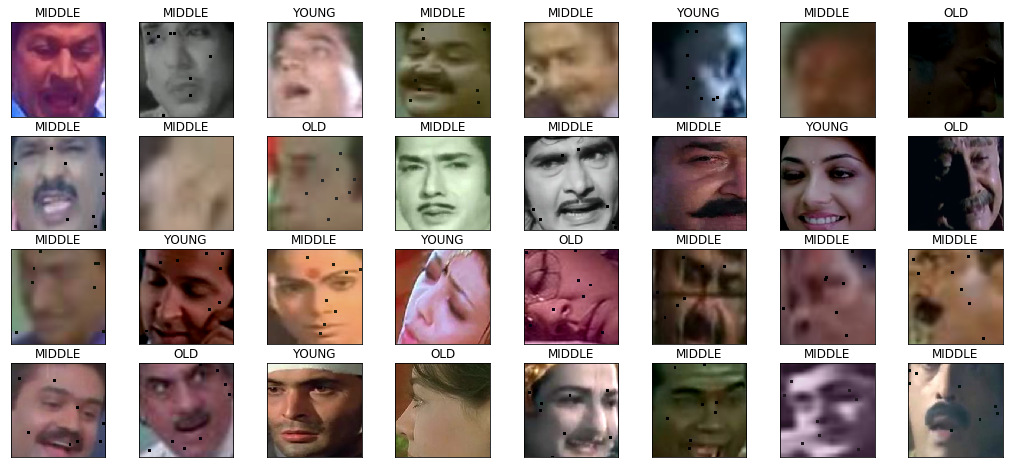

In [19]:
dataiter = iter(train_dl)
img,label = dataiter.next()
def im_show(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
fig = plt.figure(figsize=(18,8))

for i in np.arange(32):
    ax = fig.add_subplot(4,8,i+1,xticks=[],yticks=[])
    im_show(img[i])
    ax.set_title(ages[label[i]])

In [25]:
resnet = models.resnet50(pretrained=True)

In [26]:
#for param in resnet.parameters():
#    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs,3)
resnet = resnet.to(device)

In [46]:
for p in resnet.parameters():
    p.requires_grad = True

In [44]:
dloaders = {'train':train_dl, 'val':val_dl}
trainer1 = Trainer(resnet,dloaders,30)

In [47]:
model,loss,acc = trainer1.train()

Epoch [1/30] train loss: 0.9249 acc: 0.5637 val loss: 0.8728 acc: 0.6080 time: 213.8997
Epoch [2/30] train loss: 0.9064 acc: 0.5710 val loss: 0.9051 acc: 0.5703 time: 213.1517
Epoch [3/30] train loss: 0.9032 acc: 0.5690 val loss: 0.8866 acc: 0.5866 time: 212.0515
Epoch [4/30] train loss: 0.8974 acc: 0.5750 val loss: 0.8978 acc: 0.5763 time: 214.2688
Epoch [5/30] train loss: 0.8906 acc: 0.5828 val loss: 0.8741 acc: 0.5977 time: 214.9812
Epoch [6/30] train loss: 0.8645 acc: 0.6095 val loss: 0.8569 acc: 0.6200 time: 214.5262
Epoch [7/30] train loss: 0.8437 acc: 0.6220 val loss: 0.8075 acc: 0.6547 time: 213.5019
Epoch [8/30] train loss: 0.8236 acc: 0.6342 val loss: 0.7892 acc: 0.6519 time: 214.0198
Epoch [9/30] train loss: 0.7990 acc: 0.6503 val loss: 0.7628 acc: 0.6760 time: 213.3500
Epoch [10/30] train loss: 0.7826 acc: 0.6545 val loss: 0.7565 acc: 0.6846 time: 212.7945
Epoch [11/30] train loss: 0.7637 acc: 0.6621 val loss: 0.7638 acc: 0.6665 time: 213.0042
Epoch [12/30] train loss: 0.75

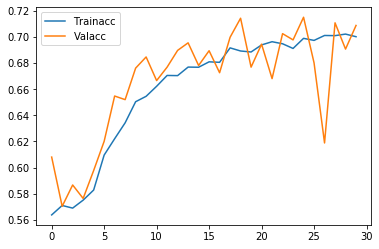

In [48]:
epoch = []
for x in range(30):
    epoch.append(x)
plt.plot(epoch,acc['train'],label = 'Trainacc')
plt.plot(epoch,acc['val'],label = 'Valacc')
plt.legend()
plt.show()

In [52]:
trainer1.load('/notebooks/best-checkpoint-024epoch.bin')
resnet = trainer1.model

In [49]:
lab = pd.read_csv('/notebooks/sample_submission_sDO3m7O.csv')

In [50]:
test_data = data(lab,'/notebooks/Test/','test',transform = ts_trns)
test_dl = DataLoader(test_data, batch_size=16)

In [51]:
final_submit = pd.read_csv('/notebooks/sample_submission_sDO3m7O.csv')
model.train(False)
preds = []
for x in test_dl:
    x = x.cuda()
    scores = model(x)
    preds.append(scores.data.cpu().numpy())
preds = np.concatenate(preds)
preds = np.argmax(preds,axis=1)
final_submit.iloc[:,0]=ages[preds]
final_submit.to_csv("res50.csv", index = False)